In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, RMSprop, Adam
import cv2
from faster_rcnn.network import  clip_gradient
from faster_rcnn.faster_rcnn import FasterRCNN
from pycrayon import CrayonClient
import torch
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
from torch.optim.lr_scheduler import StepLR

/data
/data/data/mscoco


In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer


dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'
images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
              )

loading annotations into memory...
Done (t=14.48s)
creating index...
index created!


In [4]:
data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=1)
t = queue.get()


In [5]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated



In [6]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(255, 255, 0), font=font)
    del draw
    ax.imshow(image)

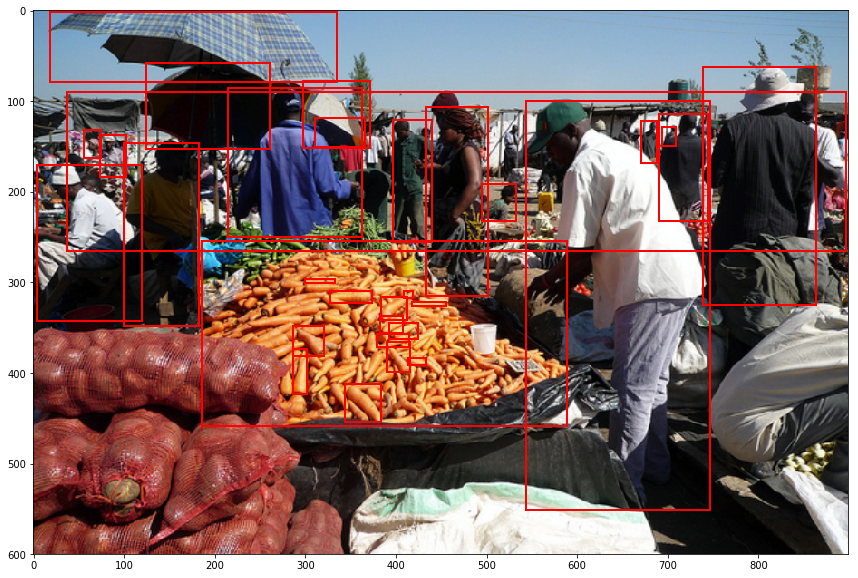

In [7]:
blobs = t.next()
rois_index = np.where(blobs['gt_classes']==0)
gt_index = np.where(blobs['gt_classes'] != 0)
gt_boxes = blobs['boxes'][gt_index]
gt_classes = blobs['gt_classes'][gt_index]
proposals = blobs['boxes'][rois_index]
rois = blobs['boxes'][rois_index]
rois = np.hstack((np.zeros((rois.shape[0], 1)), rois))
rois.shape
imshow(blobs['tensor'][0], gt_boxes, proposals)

In [8]:
disp_interval = 100
log_interval = 100
save_interval = 10000

In [9]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [10]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anh/.torch/models/vgg16-397923af.pth
100.0%


FasterRCNN(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(

In [11]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [12]:
optimizer = SGD(param, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [15]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0
    rpn_loss = 0

    for epoch in range(epochs):
        
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()
            blobs = data_gen.next()
            im_data = blobs['tensor']
            im_info = blobs['im_info']
            gt_boxes = blobs['boxes']
            gt_classes = blobs['gt_classes']
            gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
            try:
                cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
            except Exception as e:
                print e
                continue

            cls_data = cls_prob.data.cpu().numpy()
            max_class_idx = np.argmax(cls_data, axis=1)
            loss = model.loss
            cross_entropy += model.cross_entropy.data[0]
            loss_box += model.loss_box.data[0]
            train_loss += loss.data[0]
            rpn_loss += model.rpn.loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % disp_interval == 0:
                log_text = 'step %d, image: %s, loss: %.4f' % (
                    step, blobs['im_name'], train_loss /(step))
                print(log_text)

                re_cnt = True

            if step % log_interval == 0:
                exp.add_scalar_value('train_loss', train_loss / step, step=step)
                exp.add_scalar_value('rpn_loss', rpn_loss / step, step=step)
                exp.add_scalar_value('cross_entropy', cross_entropy / step, step=step)
                exp.add_scalar_value('loss_box', loss_box / step, step=step)

            if step % save_interval == 0:
                torch.save(model.state_dict(), 'faster_model_at_step_%s.pkl' % step)

In [ ]:
train(t, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=2, steps_per_epoch=80000)

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 100, image: COCO_train2014_000000131225.jpg, loss: 4.2625
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 200, image: COCO_train2014_000000524692.jpg, loss: 3.9376
step 300, image: COCO_train2014_000000393664.jpg, loss: 3.7340
step 400, image: COCO_train2014_000000200788.jpg, loss: 3.6210
step 500, image: COCO_train2014_000000131833.jpg, loss: 3.4899
step 600, image: COCO_train2014_000000132000.jpg, loss: 3.3940
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 700, image: COCO_train2014_000000394286.jpg, loss: 3.2912
step 800, image: COCO_train2014_000000132303.jpg, loss: 3.2436
step 900, image: COCO_train2014_000000001386.jpg, loss: 3.1998
step 1000, image: COCO_train2014_000000249659.jpg, loss: 3.1601
step 1100, image: COCO_train2014_000000001688.jpg, loss: 3.1349
step 

step 12100, image: COCO_train2014_000000411705.jpg, loss: 2.3929
step 12200, image: COCO_train2014_000000280788.jpg, loss: 2.3905
step 12300, image: COCO_train2014_000000412011.jpg, loss: 2.3875
step 12400, image: COCO_train2014_000000412167.jpg, loss: 2.3849
step 12500, image: COCO_train2014_000000543378.jpg, loss: 2.3831
step 12600, image: COCO_train2014_000000019236.jpg, loss: 2.3810
step 12700, image: COCO_train2014_000000543683.jpg, loss: 2.3792
step 12800, image: COCO_train2014_000000025102.jpg, loss: 2.3767
step 12900, image: COCO_train2014_000000150769.jpg, loss: 2.3746
step 13000, image: COCO_train2014_000000413073.jpg, loss: 2.3721
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 13100, image: COCO_train2014_000000151094.jpg, loss: 2.3694
step 13200, image: COCO_train2014_000000020164.jpg, loss: 2.3672
step 13300, image: COCO_train2014_000000282466.jpg, loss: 2.3636
step 13400, image: COCO_train2014_000000544752.jpg, los

step 24100, image: COCO_train2014_000000298793.jpg, loss: 2.1872
step 24200, image: COCO_train2014_000000324200.jpg, loss: 2.1867
step 24300, image: COCO_train2014_000000299111.jpg, loss: 2.1856
step 24400, image: COCO_train2014_000000430335.jpg, loss: 2.1842
step 24500, image: COCO_train2014_000000168335.jpg, loss: 2.1833
step 24600, image: COCO_train2014_000000561701.jpg, loss: 2.1817
step 24700, image: COCO_train2014_000000168643.jpg, loss: 2.1802
step 24800, image: COCO_train2014_000000299862.jpg, loss: 2.1790
step 24900, image: COCO_train2014_000000037863.jpg, loss: 2.1781
step 25000, image: COCO_train2014_000000431228.jpg, loss: 2.1767
step 25100, image: COCO_train2014_000000300307.jpg, loss: 2.1752
step 25200, image: COCO_train2014_000000421447.jpg, loss: 2.1744
step 25300, image: COCO_train2014_000000300624.jpg, loss: 2.1737
step 25400, image: COCO_train2014_000000300772.jpg, loss: 2.1727
step 25500, image: COCO_train2014_000000431984.jpg, loss: 2.1725
step 25600, image: COCO_t

step 36300, image: COCO_train2014_000000186246.jpg, loss: 2.0771
step 36400, image: COCO_train2014_000000579614.jpg, loss: 2.0766
step 36500, image: COCO_train2014_000000579758.jpg, loss: 2.0758
step 36600, image: COCO_train2014_000000186703.jpg, loss: 2.0750
step 36700, image: COCO_train2014_000000580052.jpg, loss: 2.0744
step 36800, image: COCO_train2014_000000055937.jpg, loss: 2.0733
step 36900, image: COCO_train2014_000000449307.jpg, loss: 2.0728
step 37000, image: COCO_train2014_000000449469.jpg, loss: 2.0724
step 37100, image: COCO_train2014_000000580695.jpg, loss: 2.0719
step 37200, image: COCO_train2014_000000318708.jpg, loss: 2.0714
step 37300, image: COCO_train2014_000000318857.jpg, loss: 2.0707
step 37400, image: COCO_train2014_000000581153.jpg, loss: 2.0701
step 37500, image: COCO_train2014_000000188085.jpg, loss: 2.0697
step 37600, image: COCO_train2014_000000450383.jpg, loss: 2.0689
step 37700, image: COCO_train2014_000000188405.jpg, loss: 2.0685
step 37800, image: COCO_t

In [19]:
torch.save(net.state_dict(), 'model.pkl')

In [20]:
net.load_state_dict(torch.load('./faster_model_at_step_80000.pkl'))

In [ ]:
torch.save(net.features.state_dict(), 'rpn.pkl')

In [13]:
blobs = cap[59778]
print blobs['im_name']
im_path = os.path.join('/data/data/mscoco/images/train2014/', blobs['im_name'])

COCO_train2014_000000012839.jpg


In [37]:
pred_boxes, scores, classes, rois, blob = net.detect('./3.jpg', thr=0.9)

(u'person', (67.276971298526846, 0.0), (295.55880106644281, 557.22218723606625))
(u'person', (410.69637848779888, 0.0), (572.99077719913942, 69.697501652003027))


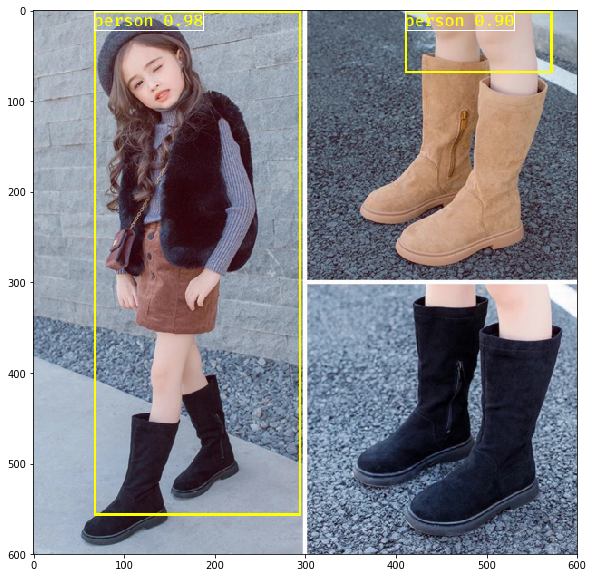

In [38]:
result_show(blob[0], pred_boxes, classes, scores)